In [1]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [2]:
print(tf.__version__)

2.10.0


In [3]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [6]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .65)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [7]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [8]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE




0    649
1     50
Name: binding, dtype: int64
0    73
1    28
Name: binding, dtype: int64


In [9]:
sampler = RandomOverSampler(sampling_strategy=.75)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    649
1    486
Name: binding, dtype: int64
0    73
1    28
Name: binding, dtype: int64


In [10]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [11]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,final_train_set.binding,.25,vectorizer_best.get_feature_names_out())
features

array(['10000', '10008', '10025', ..., '9998', '99988', '99989'],
      dtype=object)

In [12]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [13]:
# smote = (random_state=42, sampling_strategy=.65)
# x, y = smote.fit_resample(training_split, train_result)
# training_split = x
# train_result = y
# print(training_split.shape)
# print(test_split.shape)

In [14]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [15]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [16]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [17]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( .10 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [18]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .35 and current_train_precision > .82:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [19]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.015)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [20]:
ensemble_size = 50
ensemble = []
alphas = []
sample_percentage = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        score = ((sum(train_res)/len(train_res)))*100
        sample_percentage.append( score )
        print( "bfore traning: ",score )
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = .012 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [21]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
Metal device set to: Apple M1
bfore traning:  41.5929203539823
Epoch 1/60


2022-11-15 12:05:20.389834: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 12:05:20.389939: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-15 12:05:20.541442: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-15 12:05:20.819646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 113ms/step - loss: 5.2728 - tp: 12.0000 - fp: 11.0000 - tn: 55.0000 - fn: 35.0000 - precision: 0.5217 - recall: 0.2553
Epoch 2/60
2/2 [==============================] - 0s 18ms/step - loss: 4.1706 - tp: 14.0000 - fp: 8.0000 - tn: 58.0000 - fn: 33.0000 - precision: 0.6364 - recall: 0.2979
Epoch 3/60
2/2 [==============================] - 0s 13ms/step - loss: 3.2352 - tp: 18.0000 - fp: 4.0000 - tn: 62.0000 - fn: 29.0000 - precision: 0.8182 - recall: 0.3830
Epoch 4/60
2/2 [==============================] - 0s 16ms/step - loss: 2.4525 - tp: 15.0000 - fp: 2.0000 - tn: 64.0000 - fn: 32.0000 - precision: 0.8824 - recall: 0.3191
Epoch 5/60
2/2 [==============================] - 0s 19ms/step - loss: 1.8212 - tp: 12.0000 - fp: 1.0000 - tn: 65.0000 - fn: 35.0000 - precision: 0.9231 - recall: 0.2553
Epoch 6/60
2/2 [==============================] - 0s 16ms/step - loss: 1.3429 - tp: 7.0000 - fp: 0.0000e+00 - tn: 66.0000 - fn: 40.0000 - precision: 1.0000 - r

2022-11-15 12:05:21.719263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.3691275167785235
0.6687224669603524
error_rate: 0.00029187447844902884
1.0000000000000029
 =========== iteration ===========>: 1
bfore traning:  46.017699115044245
Epoch 1/60


2022-11-15 12:05:22.217194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 108ms/step - loss: 5.2620 - tp: 21.0000 - fp: 17.0000 - tn: 44.0000 - fn: 31.0000 - precision: 0.5526 - recall: 0.4038
Epoch 2/60
2/2 [==============================] - 0s 21ms/step - loss: 4.1535 - tp: 21.0000 - fp: 15.0000 - tn: 46.0000 - fn: 31.0000 - precision: 0.5833 - recall: 0.4038
Epoch 3/60
2/2 [==============================] - 0s 16ms/step - loss: 3.2133 - tp: 27.0000 - fp: 13.0000 - tn: 48.0000 - fn: 25.0000 - precision: 0.6750 - recall: 0.5192
Epoch 4/60
2/2 [==============================] - 0s 16ms/step - loss: 2.4318 - tp: 30.0000 - fp: 11.0000 - tn: 50.0000 - fn: 22.0000 - precision: 0.7317 - recall: 0.5769
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9076 - tp: 21.0000 - fp: 6.0000 - tn: 32.0000 - fn: 11.0000 - precision: 0.7778 - recall: 0.6562

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7628866209463352
Recall TRAINING:  0.7115384936332703
2/2 [==============================] - 0s 17ms

2022-11-15 12:05:22.838576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:23.255077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 121ms/step - loss: 5.2691 - tp: 28.0000 - fp: 32.0000 - tn: 28.0000 - fn: 25.0000 - precision: 0.4667 - recall: 0.5283
Epoch 2/60
2/2 [==============================] - 0s 21ms/step - loss: 4.1736 - tp: 39.0000 - fp: 35.0000 - tn: 25.0000 - fn: 14.0000 - precision: 0.5270 - recall: 0.7358
Epoch 3/60
2/2 [==============================] - 0s 21ms/step - loss: 3.2349 - tp: 37.0000 - fp: 18.0000 - tn: 42.0000 - fn: 16.0000 - precision: 0.6727 - recall: 0.6981
Epoch 4/60
2/2 [==============================] - 0s 19ms/step - loss: 2.4524 - tp: 45.0000 - fp: 10.0000 - tn: 50.0000 - fn: 8.0000 - precision: 0.8182 - recall: 0.8491
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9249 - tp: 34.0000 - fp: 6.0000 - tn: 29.0000 - fn: 1.0000 - precision: 0.8500 - recall: 0.9714

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8947368983893652
Recall TRAINING:  0.9622641801834106
2/2 [==============================] - 0s 15ms/s

2022-11-15 12:05:23.886953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


bfore traning:  42.47787610619469
Epoch 1/60


2022-11-15 12:05:24.341098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 132ms/step - loss: 5.2310 - tp: 10.0000 - fp: 15.0000 - tn: 50.0000 - fn: 38.0000 - precision: 0.4000 - recall: 0.2083
Epoch 2/60
2/2 [==============================] - 0s 20ms/step - loss: 4.1198 - tp: 6.0000 - fp: 4.0000 - tn: 61.0000 - fn: 42.0000 - precision: 0.6000 - recall: 0.1250
Epoch 3/60
2/2 [==============================] - 0s 17ms/step - loss: 3.1781 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 48.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
2/2 [==============================] - 0s 18ms/step - loss: 2.3975 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 48.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
2/2 [==============================] - 0s 20ms/step - loss: 1.7790 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 65.0000 - fn: 48.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
2/2 [==============================] - 0s 18ms/step - loss: 1.3188 - tp: 0.0000e+00 - fp: 0.0000e+00 - t

2022-11-15 12:05:26.770875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_11741/1992033442.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)
2022-11-15 12:05:27.173223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 149ms/step - loss: 5.2518 - tp: 48.0000 - fp: 41.0000 - tn: 15.0000 - fn: 9.0000 - precision: 0.5393 - recall: 0.8421
Epoch 2/60
2/2 [==============================] - 0s 20ms/step - loss: 4.1440 - tp: 53.0000 - fp: 37.0000 - tn: 19.0000 - fn: 4.0000 - precision: 0.5889 - recall: 0.9298
Epoch 3/60
2/2 [==============================] - 0s 23ms/step - loss: 3.1978 - tp: 53.0000 - fp: 37.0000 - tn: 19.0000 - fn: 4.0000 - precision: 0.5889 - recall: 0.9298
Epoch 4/60
2/2 [==============================] - 0s 23ms/step - loss: 2.4145 - tp: 53.0000 - fp: 31.0000 - tn: 25.0000 - fn: 4.0000 - precision: 0.6310 - recall: 0.9298
Epoch 5/60
2/2 [==============================] - 0s 15ms/step - loss: 1.7881 - tp: 53.0000 - fp: 24.0000 - tn: 32.0000 - fn: 4.0000 - precision: 0.6883 - recall: 0.9298
Epoch 6/60
2/2 [==============================] - 0s 12ms/step - loss: 1.3153 - tp: 54.0000 - fp: 18.0000 - tn: 38.0000 - fn: 3.0000 - precision: 0.7500 - recal

2022-11-15 12:05:27.925772: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:28.330609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 129ms/step - loss: 5.2612 - tp: 17.0000 - fp: 24.0000 - tn: 35.0000 - fn: 37.0000 - precision: 0.4146 - recall: 0.3148
Epoch 2/60
2/2 [==============================] - 0s 35ms/step - loss: 4.1526 - tp: 20.0000 - fp: 19.0000 - tn: 40.0000 - fn: 34.0000 - precision: 0.5128 - recall: 0.3704
Epoch 3/60
2/2 [==============================] - 0s 20ms/step - loss: 3.2089 - tp: 32.0000 - fp: 15.0000 - tn: 44.0000 - fn: 22.0000 - precision: 0.6809 - recall: 0.5926
Epoch 4/60
2/2 [==============================] - 0s 23ms/step - loss: 2.4232 - tp: 38.0000 - fp: 14.0000 - tn: 45.0000 - fn: 16.0000 - precision: 0.7308 - recall: 0.7037
Epoch 5/60
2/2 [==============================] - 0s 13ms/step - loss: 1.8007 - tp: 47.0000 - fp: 16.0000 - tn: 43.0000 - fn: 7.0000 - precision: 0.7460 - recall: 0.8704
Epoch 6/60
2/2 [==============================] - 0s 13ms/step - loss: 1.3320 - tp: 53.0000 - fp: 17.0000 - tn: 42.0000 - fn: 1.0000 - precision: 0.7571 - r

2022-11-15 12:05:29.090093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:29.495320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 161ms/step - loss: 5.2234 - tp: 23.0000 - fp: 22.0000 - tn: 33.0000 - fn: 35.0000 - precision: 0.5111 - recall: 0.3966
Epoch 2/60
2/2 [==============================] - 0s 33ms/step - loss: 4.1288 - tp: 48.0000 - fp: 24.0000 - tn: 31.0000 - fn: 10.0000 - precision: 0.6667 - recall: 0.8276
Epoch 3/60
2/2 [==============================] - 0s 34ms/step - loss: 3.1957 - tp: 54.0000 - fp: 21.0000 - tn: 34.0000 - fn: 4.0000 - precision: 0.7200 - recall: 0.9310
Epoch 4/60
2/2 [==============================] - 0s 22ms/step - loss: 2.4201 - tp: 58.0000 - fp: 17.0000 - tn: 38.0000 - fn: 0.0000e+00 - precision: 0.7733 - recall: 1.0000
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9044 - tp: 35.0000 - fp: 8.0000 - tn: 26.0000 - fn: 1.0000 - precision: 0.8140 - recall: 0.9722

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.904761927768787
Recall TRAINING:  0.982758641242981
2/2 [==============================] - 0s 13ms/

2022-11-15 12:05:30.256057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:30.659810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 153ms/step - loss: 5.2760 - tp: 10.0000 - fp: 4.0000 - tn: 53.0000 - fn: 46.0000 - precision: 0.7143 - recall: 0.1786
Epoch 2/60
2/2 [==============================] - 0s 13ms/step - loss: 4.1928 - tp: 48.0000 - fp: 15.0000 - tn: 42.0000 - fn: 8.0000 - precision: 0.7619 - recall: 0.8571
Epoch 3/60
1/2 [==============>...............] - ETA: 0s - loss: 3.4358 - tp: 35.0000 - fp: 8.0000 - tn: 23.0000 - fn: 4.0000 - precision: 0.8140 - recall: 0.8974

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.873949634162612
Recall TRAINING:  0.9285714626312256
2/2 [==============================] - 0s 38ms/step - loss: 3.2679 - tp: 52.0000 - fp: 11.0000 - tn: 46.0000 - fn: 4.0000 - precision: 0.8254 - recall: 0.9286



****** Early Stopping *******
36/36 [==============================] - 0s 3ms/step
0.7681007345225604
0.8052863436123348
error_rate: 0.00018747034885162903
0.9999999999999964
 =========== iteration ===========>: 8
bfore traning:  

2022-11-15 12:05:31.331730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:31.814487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 146ms/step - loss: 5.2558 - tp: 44.0000 - fp: 45.0000 - tn: 17.0000 - fn: 7.0000 - precision: 0.4944 - recall: 0.8627
Epoch 2/60
2/2 [==============================] - 0s 37ms/step - loss: 4.1598 - tp: 45.0000 - fp: 41.0000 - tn: 21.0000 - fn: 6.0000 - precision: 0.5233 - recall: 0.8824
Epoch 3/60
2/2 [==============================] - 0s 28ms/step - loss: 3.2252 - tp: 45.0000 - fp: 26.0000 - tn: 36.0000 - fn: 6.0000 - precision: 0.6338 - recall: 0.8824
Epoch 4/60
2/2 [==============================] - 0s 20ms/step - loss: 2.4481 - tp: 50.0000 - fp: 16.0000 - tn: 46.0000 - fn: 1.0000 - precision: 0.7576 - recall: 0.9804
Epoch 5/60
2/2 [==============================] - 0s 22ms/step - loss: 1.8254 - tp: 50.0000 - fp: 16.0000 - tn: 46.0000 - fn: 1.0000 - precision: 0.7576 - recall: 0.9804
Epoch 6/60
2/2 [==============================] - 0s 18ms/step - loss: 1.3478 - tp: 51.0000 - fp: 13.0000 - tn: 49.0000 - fn: 0.0000e+00 - precision: 0.7969 - r

2022-11-15 12:05:32.750420: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:33.149392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 182ms/step - loss: 5.3016 - tp: 5.0000 - fp: 4.0000 - tn: 54.0000 - fn: 50.0000 - precision: 0.5556 - recall: 0.0909
Epoch 2/60
2/2 [==============================] - 0s 27ms/step - loss: 4.2052 - tp: 26.0000 - fp: 9.0000 - tn: 49.0000 - fn: 29.0000 - precision: 0.7429 - recall: 0.4727
Epoch 3/60
2/2 [==============================] - 0s 24ms/step - loss: 3.2732 - tp: 27.0000 - fp: 10.0000 - tn: 48.0000 - fn: 28.0000 - precision: 0.7297 - recall: 0.4909
Epoch 4/60
2/2 [==============================] - 0s 24ms/step - loss: 2.4889 - tp: 30.0000 - fp: 8.0000 - tn: 50.0000 - fn: 25.0000 - precision: 0.7895 - recall: 0.5455
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9581 - tp: 21.0000 - fp: 4.0000 - tn: 33.0000 - fn: 12.0000 - precision: 0.8400 - recall: 0.6364

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7676768067442331
Recall TRAINING:  0.6909091472625732
2/2 [==============================] - 0s 17ms/ste

2022-11-15 12:05:33.829819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:34.229635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 149ms/step - loss: 5.2511 - tp: 3.0000 - fp: 5.0000 - tn: 51.0000 - fn: 54.0000 - precision: 0.3750 - recall: 0.0526
Epoch 2/60
2/2 [==============================] - 0s 45ms/step - loss: 4.1441 - tp: 21.0000 - fp: 19.0000 - tn: 37.0000 - fn: 36.0000 - precision: 0.5250 - recall: 0.3684
Epoch 3/60
2/2 [==============================] - 0s 25ms/step - loss: 3.2019 - tp: 29.0000 - fp: 19.0000 - tn: 37.0000 - fn: 28.0000 - precision: 0.6042 - recall: 0.5088
Epoch 4/60
2/2 [==============================] - 0s 33ms/step - loss: 2.4196 - tp: 44.0000 - fp: 17.0000 - tn: 39.0000 - fn: 13.0000 - precision: 0.7213 - recall: 0.7719
Epoch 5/60
2/2 [==============================] - 0s 23ms/step - loss: 1.7956 - tp: 49.0000 - fp: 12.0000 - tn: 44.0000 - fn: 8.0000 - precision: 0.8033 - recall: 0.8596
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.3990 - tp: 24.0000 - fp: 5.0000 - tn: 32.0000 - fn: 9.0000 - precision: 0.8276 - recall: 0

2022-11-15 12:05:35.006928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:35.429790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 220ms/step - loss: 5.2923 - tp: 25.0000 - fp: 19.0000 - tn: 33.0000 - fn: 36.0000 - precision: 0.5682 - recall: 0.4098
Epoch 2/60
2/2 [==============================] - 0s 43ms/step - loss: 4.2074 - tp: 52.0000 - fp: 27.0000 - tn: 25.0000 - fn: 9.0000 - precision: 0.6582 - recall: 0.8525
Epoch 3/60
2/2 [==============================] - 0s 53ms/step - loss: 3.2703 - tp: 56.0000 - fp: 28.0000 - tn: 24.0000 - fn: 5.0000 - precision: 0.6667 - recall: 0.9180
Epoch 4/60
2/2 [==============================] - 0s 16ms/step - loss: 2.4821 - tp: 57.0000 - fp: 24.0000 - tn: 28.0000 - fn: 4.0000 - precision: 0.7037 - recall: 0.9344
Epoch 5/60
2/2 [==============================] - 0s 24ms/step - loss: 1.8504 - tp: 58.0000 - fp: 21.0000 - tn: 31.0000 - fn: 3.0000 - precision: 0.7342 - recall: 0.9508
Epoch 6/60
2/2 [==============================] - 0s 14ms/step - loss: 1.3702 - tp: 58.0000 - fp: 14.0000 - tn: 38.0000 - fn: 3.0000 - precision: 0.8056 - reca

2022-11-15 12:05:36.333673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:36.755476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 239ms/step - loss: 5.2541 - tp: 35.0000 - fp: 46.0000 - tn: 21.0000 - fn: 11.0000 - precision: 0.4321 - recall: 0.7609
Epoch 2/60
2/2 [==============================] - 0s 52ms/step - loss: 4.1456 - tp: 35.0000 - fp: 38.0000 - tn: 29.0000 - fn: 11.0000 - precision: 0.4795 - recall: 0.7609
Epoch 3/60
2/2 [==============================] - 0s 25ms/step - loss: 3.2034 - tp: 39.0000 - fp: 33.0000 - tn: 34.0000 - fn: 7.0000 - precision: 0.5417 - recall: 0.8478
Epoch 4/60
2/2 [==============================] - 0s 37ms/step - loss: 2.4210 - tp: 41.0000 - fp: 28.0000 - tn: 39.0000 - fn: 5.0000 - precision: 0.5942 - recall: 0.8913
Epoch 5/60
2/2 [==============================] - 0s 40ms/step - loss: 1.7970 - tp: 44.0000 - fp: 21.0000 - tn: 46.0000 - fn: 2.0000 - precision: 0.6769 - recall: 0.9565
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.3970 - tp: 32.0000 - fp: 5.0000 - tn: 33.0000 - fn: 0.0000e+00 - precision: 0.8649 - recal

2022-11-15 12:05:37.733231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:38.141683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 239ms/step - loss: 5.2517 - tp: 21.0000 - fp: 22.0000 - tn: 47.0000 - fn: 23.0000 - precision: 0.4884 - recall: 0.4773
Epoch 2/60
2/2 [==============================] - 0s 28ms/step - loss: 4.1459 - tp: 21.0000 - fp: 20.0000 - tn: 49.0000 - fn: 23.0000 - precision: 0.5122 - recall: 0.4773
Epoch 3/60
2/2 [==============================] - 0s 30ms/step - loss: 3.2063 - tp: 23.0000 - fp: 19.0000 - tn: 50.0000 - fn: 21.0000 - precision: 0.5476 - recall: 0.5227
Epoch 4/60
2/2 [==============================] - 0s 40ms/step - loss: 2.4245 - tp: 27.0000 - fp: 14.0000 - tn: 55.0000 - fn: 17.0000 - precision: 0.6585 - recall: 0.6136
Epoch 5/60
2/2 [==============================] - 0s 42ms/step - loss: 1.8007 - tp: 31.0000 - fp: 10.0000 - tn: 59.0000 - fn: 13.0000 - precision: 0.7561 - recall: 0.7045
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4042 - tp: 19.0000 - fp: 3.0000 - tn: 42.0000 - fn: 6.0000 - precision: 0.8636 - recall

2022-11-15 12:05:39.163723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:39.582065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 252ms/step - loss: 5.2842 - tp: 17.0000 - fp: 25.0000 - tn: 36.0000 - fn: 35.0000 - precision: 0.4048 - recall: 0.3269
Epoch 2/60
2/2 [==============================] - 0s 60ms/step - loss: 4.1732 - tp: 13.0000 - fp: 20.0000 - tn: 41.0000 - fn: 39.0000 - precision: 0.3939 - recall: 0.2500
Epoch 3/60
2/2 [==============================] - 0s 26ms/step - loss: 3.2234 - tp: 11.0000 - fp: 18.0000 - tn: 43.0000 - fn: 41.0000 - precision: 0.3793 - recall: 0.2115
Epoch 4/60
2/2 [==============================] - 0s 44ms/step - loss: 2.4339 - tp: 16.0000 - fp: 13.0000 - tn: 48.0000 - fn: 36.0000 - precision: 0.5517 - recall: 0.3077
Epoch 5/60
2/2 [==============================] - 0s 27ms/step - loss: 1.8043 - tp: 18.0000 - fp: 10.0000 - tn: 51.0000 - fn: 34.0000 - precision: 0.6429 - recall: 0.3462
Epoch 6/60
2/2 [==============================] - 0s 26ms/step - loss: 1.3322 - tp: 22.0000 - fp: 5.0000 - tn: 56.0000 - fn: 30.0000 - precision: 0.8148 - 

2022-11-15 12:05:40.652341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:41.068417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 228ms/step - loss: 5.2671 - tp: 27.0000 - fp: 37.0000 - tn: 29.0000 - fn: 20.0000 - precision: 0.4219 - recall: 0.5745
Epoch 2/60
2/2 [==============================] - 0s 51ms/step - loss: 4.1586 - tp: 27.0000 - fp: 35.0000 - tn: 31.0000 - fn: 20.0000 - precision: 0.4355 - recall: 0.5745
Epoch 3/60
2/2 [==============================] - 0s 18ms/step - loss: 3.2165 - tp: 27.0000 - fp: 26.0000 - tn: 40.0000 - fn: 20.0000 - precision: 0.5094 - recall: 0.5745
Epoch 4/60
2/2 [==============================] - 0s 13ms/step - loss: 2.4329 - tp: 29.0000 - fp: 15.0000 - tn: 51.0000 - fn: 18.0000 - precision: 0.6591 - recall: 0.6170
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9113 - tp: 19.0000 - fp: 4.0000 - tn: 37.0000 - fn: 10.0000 - precision: 0.8261 - recall: 0.6552

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7529412022428937
Recall TRAINING:  0.6808511018753052
2/2 [==============================] - 0s 34ms

2022-11-15 12:05:41.995113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:42.417588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 223ms/step - loss: 5.2822 - tp: 49.0000 - fp: 45.0000 - tn: 12.0000 - fn: 7.0000 - precision: 0.5213 - recall: 0.8750
Epoch 2/60
2/2 [==============================] - 0s 61ms/step - loss: 4.1848 - tp: 49.0000 - fp: 39.0000 - tn: 18.0000 - fn: 7.0000 - precision: 0.5568 - recall: 0.8750
Epoch 3/60
2/2 [==============================] - 0s 58ms/step - loss: 3.2523 - tp: 53.0000 - fp: 27.0000 - tn: 30.0000 - fn: 3.0000 - precision: 0.6625 - recall: 0.9464
Epoch 4/60
2/2 [==============================] - 0s 25ms/step - loss: 2.4708 - tp: 54.0000 - fp: 18.0000 - tn: 39.0000 - fn: 2.0000 - precision: 0.7500 - recall: 0.9643
Epoch 5/60
2/2 [==============================] - 0s 13ms/step - loss: 1.8416 - tp: 54.0000 - fp: 12.0000 - tn: 45.0000 - fn: 2.0000 - precision: 0.8182 - recall: 0.9643
Epoch 6/60
2/2 [==============================] - 0s 15ms/step - loss: 1.3631 - tp: 56.0000 - fp: 17.0000 - tn: 40.0000 - fn: 0.0000e+00 - precision: 0.7671 - r

2022-11-15 12:05:43.601476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:44.119446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 236ms/step - loss: 5.2159 - tp: 10.0000 - fp: 14.0000 - tn: 52.0000 - fn: 37.0000 - precision: 0.4167 - recall: 0.2128
Epoch 2/60
2/2 [==============================] - 0s 43ms/step - loss: 4.1181 - tp: 17.0000 - fp: 12.0000 - tn: 54.0000 - fn: 30.0000 - precision: 0.5862 - recall: 0.3617
Epoch 3/60
2/2 [==============================] - 0s 55ms/step - loss: 3.1829 - tp: 21.0000 - fp: 11.0000 - tn: 55.0000 - fn: 26.0000 - precision: 0.6562 - recall: 0.4468
Epoch 4/60
2/2 [==============================] - 0s 26ms/step - loss: 2.4054 - tp: 24.0000 - fp: 11.0000 - tn: 55.0000 - fn: 23.0000 - precision: 0.6857 - recall: 0.5106
Epoch 5/60
2/2 [==============================] - 0s 21ms/step - loss: 1.7880 - tp: 20.0000 - fp: 6.0000 - tn: 60.0000 - fn: 27.0000 - precision: 0.7692 - recall: 0.4255
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4006 - tp: 10.0000 - fp: 1.0000 - tn: 37.0000 - fn: 22.0000 - precision: 0.9091 - recall

2022-11-15 12:05:45.143870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:45.551531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 211ms/step - loss: 5.2642 - tp: 33.0000 - fp: 44.0000 - tn: 18.0000 - fn: 18.0000 - precision: 0.4286 - recall: 0.6471
Epoch 2/60
2/2 [==============================] - 0s 38ms/step - loss: 4.1562 - tp: 34.0000 - fp: 31.0000 - tn: 31.0000 - fn: 17.0000 - precision: 0.5231 - recall: 0.6667
Epoch 3/60
2/2 [==============================] - 0s 47ms/step - loss: 3.2153 - tp: 35.0000 - fp: 29.0000 - tn: 33.0000 - fn: 16.0000 - precision: 0.5469 - recall: 0.6863
Epoch 4/60
2/2 [==============================] - 0s 13ms/step - loss: 2.4334 - tp: 35.0000 - fp: 26.0000 - tn: 36.0000 - fn: 16.0000 - precision: 0.5738 - recall: 0.6863
Epoch 5/60
2/2 [==============================] - 0s 22ms/step - loss: 1.8059 - tp: 40.0000 - fp: 15.0000 - tn: 47.0000 - fn: 11.0000 - precision: 0.7273 - recall: 0.7843
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4051 - tp: 30.0000 - fp: 2.0000 - tn: 36.0000 - fn: 2.0000 - precision: 0.9375 - recall

2022-11-15 12:05:46.524896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:46.929010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 215ms/step - loss: 5.2397 - tp: 42.0000 - fp: 46.0000 - tn: 13.0000 - fn: 12.0000 - precision: 0.4773 - recall: 0.7778
Epoch 2/60
2/2 [==============================] - 0s 41ms/step - loss: 4.1312 - tp: 41.0000 - fp: 47.0000 - tn: 12.0000 - fn: 13.0000 - precision: 0.4659 - recall: 0.7593
Epoch 3/60
2/2 [==============================] - 0s 40ms/step - loss: 3.1895 - tp: 46.0000 - fp: 47.0000 - tn: 12.0000 - fn: 8.0000 - precision: 0.4946 - recall: 0.8519
Epoch 4/60
2/2 [==============================] - 0s 40ms/step - loss: 2.4109 - tp: 49.0000 - fp: 44.0000 - tn: 15.0000 - fn: 5.0000 - precision: 0.5269 - recall: 0.9074
Epoch 5/60
2/2 [==============================] - 0s 20ms/step - loss: 1.7888 - tp: 50.0000 - fp: 32.0000 - tn: 27.0000 - fn: 4.0000 - precision: 0.6098 - recall: 0.9259
Epoch 6/60
2/2 [==============================] - 0s 45ms/step - loss: 1.3183 - tp: 53.0000 - fp: 23.0000 - tn: 36.0000 - fn: 1.0000 - precision: 0.6974 - rec

2022-11-15 12:05:48.113740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:48.522371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 205ms/step - loss: 5.2716 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 70.0000 - fn: 43.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
2/2 [==============================] - 0s 71ms/step - loss: 4.1693 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 70.0000 - fn: 43.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
2/2 [==============================] - 0s 19ms/step - loss: 3.2305 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 70.0000 - fn: 43.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
2/2 [==============================] - 0s 54ms/step - loss: 2.4460 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 70.0000 - fn: 43.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
2/2 [==============================] - 0s 12ms/step - loss: 1.8183 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 70.0000 - fn: 43.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
2/2 [==============================] - 0s 11ms/step - loss: 1.3435 - tp: 0

2022-11-15 12:05:51.119394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_11741/1992033442.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)
2022-11-15 12:05:51.530003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 274ms/step - loss: 5.2821 - tp: 43.0000 - fp: 46.0000 - tn: 12.0000 - fn: 12.0000 - precision: 0.4831 - recall: 0.7818
Epoch 2/60
2/2 [==============================] - 0s 49ms/step - loss: 4.1792 - tp: 47.0000 - fp: 37.0000 - tn: 21.0000 - fn: 8.0000 - precision: 0.5595 - recall: 0.8545
Epoch 3/60
2/2 [==============================] - 0s 38ms/step - loss: 3.2501 - tp: 49.0000 - fp: 21.0000 - tn: 37.0000 - fn: 6.0000 - precision: 0.7000 - recall: 0.8909
Epoch 4/60
2/2 [==============================] - 0s 32ms/step - loss: 2.4752 - tp: 52.0000 - fp: 15.0000 - tn: 43.0000 - fn: 3.0000 - precision: 0.7761 - recall: 0.9455
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9492 - tp: 34.0000 - fp: 4.0000 - tn: 30.0000 - fn: 2.0000 - precision: 0.8947 - recall: 0.9444

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.921739201689938
Recall TRAINING:  0.9636364579200745
2/2 [==============================] - 0s 22ms/step

2022-11-15 12:05:52.597973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:53.003225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 321ms/step - loss: 5.2441 - tp: 5.0000 - fp: 4.0000 - tn: 59.0000 - fn: 45.0000 - precision: 0.5556 - recall: 0.1000
Epoch 2/60
2/2 [==============================] - 0s 82ms/step - loss: 4.1416 - tp: 28.0000 - fp: 13.0000 - tn: 50.0000 - fn: 22.0000 - precision: 0.6829 - recall: 0.5600
Epoch 3/60
2/2 [==============================] - 0s 57ms/step - loss: 3.2076 - tp: 41.0000 - fp: 12.0000 - tn: 51.0000 - fn: 9.0000 - precision: 0.7736 - recall: 0.8200
Epoch 4/60
1/2 [==============>...............] - ETA: 0s - loss: 2.5582 - tp: 26.0000 - fp: 7.0000 - tn: 33.0000 - fn: 4.0000 - precision: 0.7879 - recall: 0.8667

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8543689363424599
Recall TRAINING:  0.8799999952316284
2/2 [==============================] - 0s 48ms/step - loss: 2.4282 - tp: 44.0000 - fp: 9.0000 - tn: 54.0000 - fn: 6.0000 - precision: 0.8302 - recall: 0.8800



****** Early Stopping *******
36/36 [=======================

2022-11-15 12:05:54.227330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:54.654901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 336ms/step - loss: 5.2515 - tp: 35.0000 - fp: 22.0000 - tn: 38.0000 - fn: 18.0000 - precision: 0.6140 - recall: 0.6604
Epoch 2/60
2/2 [==============================] - 0s 42ms/step - loss: 4.1577 - tp: 42.0000 - fp: 19.0000 - tn: 41.0000 - fn: 11.0000 - precision: 0.6885 - recall: 0.7925
Epoch 3/60
2/2 [==============================] - ETA: 0s - loss: 3.2240 - tp: 46.0000 - fp: 10.0000 - tn: 50.0000 - fn: 7.0000 - precision: 0.8214 - recall: 0.8679

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.84403673094056
Recall TRAINING:  0.8679245710372925
2/2 [==============================] - 0s 88ms/step - loss: 3.2240 - tp: 46.0000 - fp: 10.0000 - tn: 50.0000 - fn: 7.0000 - precision: 0.8214 - recall: 0.8679



****** Early Stopping *******
36/36 [==============================] - 0s 3ms/step
0.7630375114364135
0.771806167400881
error_rate: 0.00022592804397156933
0.9999999999999969
 =========== iteration ===========>: 24
bfore traning:

2022-11-15 12:05:55.735542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:56.163903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 327ms/step - loss: 5.2912 - tp: 13.0000 - fp: 20.0000 - tn: 43.0000 - fn: 37.0000 - precision: 0.3939 - recall: 0.2600
Epoch 2/60
2/2 [==============================] - 0s 54ms/step - loss: 4.2016 - tp: 26.0000 - fp: 19.0000 - tn: 44.0000 - fn: 24.0000 - precision: 0.5778 - recall: 0.5200
Epoch 3/60
2/2 [==============================] - 0s 36ms/step - loss: 3.2750 - tp: 31.0000 - fp: 14.0000 - tn: 49.0000 - fn: 19.0000 - precision: 0.6889 - recall: 0.6200
Epoch 4/60
2/2 [==============================] - 0s 72ms/step - loss: 2.4959 - tp: 35.0000 - fp: 12.0000 - tn: 51.0000 - fn: 15.0000 - precision: 0.7447 - recall: 0.7000
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9686 - tp: 30.0000 - fp: 1.0000 - tn: 37.0000 - fn: 2.0000 - precision: 0.9677 - recall: 0.9375

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9019607827554323
Recall TRAINING:  0.9199999570846558
2/2 [==============================] - 0s 35ms/

2022-11-15 12:05:57.472594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8557964184731385
0.8651982378854626
error_rate: 0.00016763784870863798
1.0000000000000007
 =========== iteration ===========>: 25
bfore traning:  43.36283185840708
Epoch 1/60


2022-11-15 12:05:57.898937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 319ms/step - loss: 5.2509 - tp: 25.0000 - fp: 32.0000 - tn: 32.0000 - fn: 24.0000 - precision: 0.4386 - recall: 0.5102
Epoch 2/60
2/2 [==============================] - 0s 79ms/step - loss: 4.1437 - tp: 27.0000 - fp: 28.0000 - tn: 36.0000 - fn: 22.0000 - precision: 0.4909 - recall: 0.5510
Epoch 3/60
2/2 [==============================] - 0s 39ms/step - loss: 3.2028 - tp: 29.0000 - fp: 26.0000 - tn: 38.0000 - fn: 20.0000 - precision: 0.5273 - recall: 0.5918
Epoch 4/60
2/2 [==============================] - 0s 56ms/step - loss: 2.4231 - tp: 31.0000 - fp: 20.0000 - tn: 44.0000 - fn: 18.0000 - precision: 0.6078 - recall: 0.6327
Epoch 5/60
2/2 [==============================] - 0s 39ms/step - loss: 1.7997 - tp: 33.0000 - fp: 11.0000 - tn: 53.0000 - fn: 16.0000 - precision: 0.7500 - recall: 0.6735
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4054 - tp: 25.0000 - fp: 1.0000 - tn: 38.0000 - fn: 6.0000 - precision: 0.9615 - recall

2022-11-15 12:05:59.311537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:05:59.737863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 360ms/step - loss: 5.1977 - tp: 20.0000 - fp: 25.0000 - tn: 41.0000 - fn: 27.0000 - precision: 0.4444 - recall: 0.4255
Epoch 2/60
2/2 [==============================] - 0s 47ms/step - loss: 4.1095 - tp: 23.0000 - fp: 19.0000 - tn: 47.0000 - fn: 24.0000 - precision: 0.5476 - recall: 0.4894
Epoch 3/60
2/2 [==============================] - 0s 90ms/step - loss: 3.1860 - tp: 27.0000 - fp: 9.0000 - tn: 57.0000 - fn: 20.0000 - precision: 0.7500 - recall: 0.5745
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 2.4196 - tp: 32.0000 - fp: 7.0000 - tn: 59.0000 - fn: 15.0000 - precision: 0.8205 - recall: 0.6809

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7441860736383493
Recall TRAINING:  0.6808511018753052
2/2 [==============================] - 0s 79ms/step - loss: 2.4196 - tp: 32.0000 - fp: 7.0000 - tn: 59.0000 - fn: 15.0000 - precision: 0.8205 - recall: 0.6809



****** Early Stopping *******
36/36 [===================

2022-11-15 12:06:01.111926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6919682259488085
0.6925110132158591
error_rate: 0.00028956417197746853
0.9999999999999989
 =========== iteration ===========>: 27
bfore traning:  38.93805309734513
Epoch 1/60


2022-11-15 12:06:01.546642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 328ms/step - loss: 5.2673 - tp: 9.0000 - fp: 26.0000 - tn: 43.0000 - fn: 35.0000 - precision: 0.2571 - recall: 0.2045
Epoch 2/60
2/2 [==============================] - 0s 97ms/step - loss: 4.1613 - tp: 12.0000 - fp: 24.0000 - tn: 45.0000 - fn: 32.0000 - precision: 0.3333 - recall: 0.2727
Epoch 3/60
2/2 [==============================] - 0s 80ms/step - loss: 3.2247 - tp: 12.0000 - fp: 18.0000 - tn: 51.0000 - fn: 32.0000 - precision: 0.4000 - recall: 0.2727
Epoch 4/60
2/2 [==============================] - 0s 62ms/step - loss: 2.4426 - tp: 11.0000 - fp: 9.0000 - tn: 60.0000 - fn: 33.0000 - precision: 0.5500 - recall: 0.2500
Epoch 5/60
2/2 [==============================] - 0s 26ms/step - loss: 1.8144 - tp: 15.0000 - fp: 4.0000 - tn: 65.0000 - fn: 29.0000 - precision: 0.7895 - recall: 0.3409
Epoch 6/60
2/2 [==============================] - 0s 11ms/step - loss: 1.3397 - tp: 11.0000 - fp: 1.0000 - tn: 68.0000 - fn: 33.0000 - precision: 0.9167 - rec

2022-11-15 12:06:03.168458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6900269541778976
0.7973568281938326
error_rate: 0.00017758164179898294
1.0000000000000062
 =========== iteration ===========>: 28
bfore traning:  47.78761061946903
Epoch 1/60


2022-11-15 12:06:03.733705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 343ms/step - loss: 5.2861 - tp: 5.0000 - fp: 8.0000 - tn: 51.0000 - fn: 49.0000 - precision: 0.3846 - recall: 0.0926
Epoch 2/60
2/2 [==============================] - 0s 98ms/step - loss: 4.1805 - tp: 35.0000 - fp: 23.0000 - tn: 36.0000 - fn: 19.0000 - precision: 0.6034 - recall: 0.6481
Epoch 3/60
2/2 [==============================] - 0s 65ms/step - loss: 3.2480 - tp: 45.0000 - fp: 23.0000 - tn: 36.0000 - fn: 9.0000 - precision: 0.6618 - recall: 0.8333
Epoch 4/60
2/2 [==============================] - 0s 62ms/step - loss: 2.4684 - tp: 50.0000 - fp: 20.0000 - tn: 39.0000 - fn: 4.0000 - precision: 0.7143 - recall: 0.9259
Epoch 5/60
2/2 [==============================] - 0s 34ms/step - loss: 1.8391 - tp: 53.0000 - fp: 18.0000 - tn: 41.0000 - fn: 1.0000 - precision: 0.7465 - recall: 0.9815
Epoch 6/60
2/2 [==============================] - 0s 17ms/step - loss: 1.3613 - tp: 53.0000 - fp: 14.0000 - tn: 45.0000 - fn: 1.0000 - precision: 0.7910 - recal

2022-11-15 12:06:05.348428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.41300813008130083
0.6819383259911894
error_rate: 0.000308012056062708
0.9999999999999996
 =========== iteration ===========>: 29
bfore traning:  44.24778761061947
Epoch 1/60


2022-11-15 12:06:05.791923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 389ms/step - loss: 5.2449 - tp: 28.0000 - fp: 35.0000 - tn: 28.0000 - fn: 22.0000 - precision: 0.4444 - recall: 0.5600
Epoch 2/60
2/2 [==============================] - 0s 67ms/step - loss: 4.1384 - tp: 29.0000 - fp: 33.0000 - tn: 30.0000 - fn: 21.0000 - precision: 0.4677 - recall: 0.5800
Epoch 3/60
2/2 [==============================] - 0s 57ms/step - loss: 3.1974 - tp: 28.0000 - fp: 28.0000 - tn: 35.0000 - fn: 22.0000 - precision: 0.5000 - recall: 0.5600
Epoch 4/60
2/2 [==============================] - 0s 14ms/step - loss: 2.4157 - tp: 32.0000 - fp: 25.0000 - tn: 38.0000 - fn: 18.0000 - precision: 0.5614 - recall: 0.6400
Epoch 5/60
2/2 [==============================] - 0s 73ms/step - loss: 1.7911 - tp: 35.0000 - fp: 14.0000 - tn: 49.0000 - fn: 15.0000 - precision: 0.7143 - recall: 0.7000
Epoch 6/60
2/2 [==============================] - ETA: 0s - loss: 1.3210 - tp: 39.0000 - fp: 3.0000 - tn: 60.0000 - fn: 11.0000 - precision: 0.9286 - recal

2022-11-15 12:06:07.332343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8426103646833014
0.8555066079295154
error_rate: 0.0001782080008776828
0.9999999999999994
 =========== iteration ===========>: 30
bfore traning:  47.78761061946903
Epoch 1/60


2022-11-15 12:06:07.761920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 349ms/step - loss: 5.2422 - tp: 42.0000 - fp: 34.0000 - tn: 25.0000 - fn: 12.0000 - precision: 0.5526 - recall: 0.7778
Epoch 2/60
2/2 [==============================] - 0s 76ms/step - loss: 4.1367 - tp: 45.0000 - fp: 35.0000 - tn: 24.0000 - fn: 9.0000 - precision: 0.5625 - recall: 0.8333
Epoch 3/60
2/2 [==============================] - 0s 55ms/step - loss: 3.1990 - tp: 47.0000 - fp: 27.0000 - tn: 32.0000 - fn: 7.0000 - precision: 0.6351 - recall: 0.8704
Epoch 4/60
2/2 [==============================] - 0s 39ms/step - loss: 2.4206 - tp: 49.0000 - fp: 25.0000 - tn: 34.0000 - fn: 5.0000 - precision: 0.6622 - recall: 0.9074
Epoch 5/60
2/2 [==============================] - 0s 52ms/step - loss: 1.7954 - tp: 51.0000 - fp: 25.0000 - tn: 34.0000 - fn: 3.0000 - precision: 0.6711 - recall: 0.9444
Epoch 6/60
2/2 [==============================] - 0s 42ms/step - loss: 1.3241 - tp: 54.0000 - fp: 25.0000 - tn: 34.0000 - fn: 0.0000e+00 - precision: 0.6835 - 

2022-11-15 12:06:09.508493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:06:09.937385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 362ms/step - loss: 5.2629 - tp: 30.0000 - fp: 39.0000 - tn: 29.0000 - fn: 15.0000 - precision: 0.4348 - recall: 0.6667
Epoch 2/60
2/2 [==============================] - 0s 78ms/step - loss: 4.1541 - tp: 32.0000 - fp: 34.0000 - tn: 34.0000 - fn: 13.0000 - precision: 0.4848 - recall: 0.7111
Epoch 3/60
2/2 [==============================] - 0s 74ms/step - loss: 3.2110 - tp: 32.0000 - fp: 28.0000 - tn: 40.0000 - fn: 13.0000 - precision: 0.5333 - recall: 0.7111
Epoch 4/60
2/2 [==============================] - 0s 82ms/step - loss: 2.4279 - tp: 33.0000 - fp: 22.0000 - tn: 46.0000 - fn: 12.0000 - precision: 0.6000 - recall: 0.7333
Epoch 5/60
2/2 [==============================] - 0s 32ms/step - loss: 1.8003 - tp: 37.0000 - fp: 14.0000 - tn: 54.0000 - fn: 8.0000 - precision: 0.7255 - recall: 0.8222
Epoch 6/60
2/2 [==============================] - 0s 34ms/step - loss: 1.3285 - tp: 38.0000 - fp: 9.0000 - tn: 59.0000 - fn: 7.0000 - precision: 0.8085 - re

2022-11-15 12:06:11.576814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.9236868186323091
0.93215859030837
error_rate: 0.00010389993236410151
0.9999999999999983
 =========== iteration ===========>: 32
bfore traning:  49.557522123893804
Epoch 1/60


2022-11-15 12:06:12.013890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 360ms/step - loss: 5.2602 - tp: 36.0000 - fp: 42.0000 - tn: 15.0000 - fn: 20.0000 - precision: 0.4615 - recall: 0.6429
Epoch 2/60
2/2 [==============================] - 0s 82ms/step - loss: 4.1575 - tp: 36.0000 - fp: 42.0000 - tn: 15.0000 - fn: 20.0000 - precision: 0.4615 - recall: 0.6429
Epoch 3/60
2/2 [==============================] - 0s 47ms/step - loss: 3.2162 - tp: 43.0000 - fp: 38.0000 - tn: 19.0000 - fn: 13.0000 - precision: 0.5309 - recall: 0.7679
Epoch 4/60
2/2 [==============================] - 0s 37ms/step - loss: 2.4353 - tp: 45.0000 - fp: 22.0000 - tn: 35.0000 - fn: 11.0000 - precision: 0.6716 - recall: 0.8036
Epoch 5/60
2/2 [==============================] - 0s 14ms/step - loss: 1.8100 - tp: 50.0000 - fp: 16.0000 - tn: 41.0000 - fn: 6.0000 - precision: 0.7576 - recall: 0.8929
Epoch 6/60
2/2 [==============================] - 0s 36ms/step - loss: 1.3320 - tp: 53.0000 - fp: 12.0000 - tn: 45.0000 - fn: 3.0000 - precision: 0.8154 - r

2022-11-15 12:06:13.759484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7414187643020596
0.7013215859030837
error_rate: 0.00028846487645685316
1.0000000000000002
 =========== iteration ===========>: 33
bfore traning:  48.67256637168141
Epoch 1/60


2022-11-15 12:06:14.202579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 336ms/step - loss: 5.2110 - tp: 5.0000 - fp: 3.0000 - tn: 55.0000 - fn: 50.0000 - precision: 0.6250 - recall: 0.0909
Epoch 2/60
2/2 [==============================] - 0s 39ms/step - loss: 4.1087 - tp: 28.0000 - fp: 11.0000 - tn: 47.0000 - fn: 27.0000 - precision: 0.7179 - recall: 0.5091
Epoch 3/60
2/2 [==============================] - 0s 35ms/step - loss: 3.1763 - tp: 29.0000 - fp: 11.0000 - tn: 47.0000 - fn: 26.0000 - precision: 0.7250 - recall: 0.5273
Epoch 4/60
2/2 [==============================] - 0s 61ms/step - loss: 2.3995 - tp: 36.0000 - fp: 12.0000 - tn: 46.0000 - fn: 19.0000 - precision: 0.7500 - recall: 0.6545
Epoch 5/60
2/2 [==============================] - 0s 68ms/step - loss: 1.7848 - tp: 47.0000 - fp: 11.0000 - tn: 47.0000 - fn: 8.0000 - precision: 0.8103 - recall: 0.8545
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.3962 - tp: 29.0000 - fp: 5.0000 - tn: 28.0000 - fn: 8.0000 - precision: 0.8529 - recall: 0

2022-11-15 12:06:15.682426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.747549019607843
0.8185022026431719
error_rate: 0.00016628108838861273
0.9999999999999991
 =========== iteration ===========>: 34
bfore traning:  41.5929203539823
Epoch 1/60


2022-11-15 12:06:16.120587: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 368ms/step - loss: 5.2586 - tp: 6.0000 - fp: 17.0000 - tn: 49.0000 - fn: 41.0000 - precision: 0.2609 - recall: 0.1277
Epoch 2/60
2/2 [==============================] - 0s 94ms/step - loss: 4.1517 - tp: 9.0000 - fp: 14.0000 - tn: 52.0000 - fn: 38.0000 - precision: 0.3913 - recall: 0.1915
Epoch 3/60
2/2 [==============================] - 0s 16ms/step - loss: 3.2089 - tp: 12.0000 - fp: 11.0000 - tn: 55.0000 - fn: 35.0000 - precision: 0.5217 - recall: 0.2553
Epoch 4/60
2/2 [==============================] - 0s 64ms/step - loss: 2.4282 - tp: 12.0000 - fp: 5.0000 - tn: 61.0000 - fn: 35.0000 - precision: 0.7059 - recall: 0.2553
Epoch 5/60
2/2 [==============================] - 0s 15ms/step - loss: 1.8042 - tp: 12.0000 - fp: 1.0000 - tn: 65.0000 - fn: 35.0000 - precision: 0.9231 - recall: 0.2553
Epoch 6/60
2/2 [==============================] - 0s 52ms/step - loss: 1.3310 - tp: 11.0000 - fp: 1.0000 - tn: 65.0000 - fn: 36.0000 - precision: 0.9167 - reca

2022-11-15 12:06:17.809684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6094420600858369
0.7594713656387665
error_rate: 0.00018747120902101426
1.0000000000000036
 =========== iteration ===========>: 35
bfore traning:  43.36283185840708
Epoch 1/60


2022-11-15 12:06:18.242389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 329ms/step - loss: 5.2617 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
2/2 [==============================] - 0s 82ms/step - loss: 4.1472 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
2/2 [==============================] - 0s 96ms/step - loss: 3.2004 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
2/2 [==============================] - 0s 56ms/step - loss: 2.4142 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
2/2 [==============================] - 0s 52ms/step - loss: 1.7911 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
2/2 [==============================] - 0s 18ms/step - loss: 1.3253 - tp: 0

2022-11-15 12:06:21.503495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_11741/1992033442.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)


nan
0.5718061674008811
error_rate: 0.0004044814667977719
1.0000000000000027
 =========== iteration ===========>: 36
bfore traning:  50.442477876106196
Epoch 1/60


2022-11-15 12:06:21.940419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 337ms/step - loss: 5.2523 - tp: 14.0000 - fp: 12.0000 - tn: 44.0000 - fn: 43.0000 - precision: 0.5385 - recall: 0.2456
Epoch 2/60
2/2 [==============================] - 0s 95ms/step - loss: 4.1412 - tp: 16.0000 - fp: 10.0000 - tn: 46.0000 - fn: 41.0000 - precision: 0.6154 - recall: 0.2807
Epoch 3/60
2/2 [==============================] - 0s 66ms/step - loss: 3.1973 - tp: 40.0000 - fp: 17.0000 - tn: 39.0000 - fn: 17.0000 - precision: 0.7018 - recall: 0.7018
Epoch 4/60
2/2 [==============================] - 0s 32ms/step - loss: 2.4152 - tp: 40.0000 - fp: 14.0000 - tn: 42.0000 - fn: 17.0000 - precision: 0.7407 - recall: 0.7018
Epoch 5/60
2/2 [==============================] - 0s 48ms/step - loss: 1.7952 - tp: 43.0000 - fp: 13.0000 - tn: 43.0000 - fn: 14.0000 - precision: 0.7679 - recall: 0.7544
Epoch 6/60
2/2 [==============================] - 0s 81ms/step - loss: 1.3282 - tp: 52.0000 - fp: 12.0000 - tn: 44.0000 - fn: 5.0000 - precision: 0.8125 - 

2022-11-15 12:06:23.563726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6941986234021632
0.7259911894273128
error_rate: 0.00025398025858050163
0.9999999999999969
 =========== iteration ===========>: 37
bfore traning:  46.902654867256636
Epoch 1/60


2022-11-15 12:06:24.002643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 390ms/step - loss: 5.2536 - tp: 25.0000 - fp: 27.0000 - tn: 33.0000 - fn: 28.0000 - precision: 0.4808 - recall: 0.4717
Epoch 2/60
2/2 [==============================] - 0s 96ms/step - loss: 4.1452 - tp: 31.0000 - fp: 25.0000 - tn: 35.0000 - fn: 22.0000 - precision: 0.5536 - recall: 0.5849
Epoch 3/60
2/2 [==============================] - 0s 71ms/step - loss: 3.2009 - tp: 32.0000 - fp: 22.0000 - tn: 38.0000 - fn: 21.0000 - precision: 0.5926 - recall: 0.6038
Epoch 4/60
2/2 [==============================] - 0s 41ms/step - loss: 2.4178 - tp: 34.0000 - fp: 19.0000 - tn: 41.0000 - fn: 19.0000 - precision: 0.6415 - recall: 0.6415
Epoch 5/60
2/2 [==============================] - 0s 11ms/step - loss: 1.7955 - tp: 42.0000 - fp: 13.0000 - tn: 47.0000 - fn: 11.0000 - precision: 0.7636 - recall: 0.7925
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4041 - tp: 32.0000 - fp: 3.0000 - tn: 34.0000 - fn: 1.0000 - precision: 0.9143 - recall

2022-11-15 12:06:25.556025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.777992277992278
0.7973568281938326
error_rate: 0.00018704057685605758
0.9999999999999991
 =========== iteration ===========>: 38
bfore traning:  57.52212389380531
Epoch 1/60


2022-11-15 12:06:25.988951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 364ms/step - loss: 5.2892 - tp: 6.0000 - fp: 6.0000 - tn: 42.0000 - fn: 59.0000 - precision: 0.5000 - recall: 0.0923
Epoch 2/60
2/2 [==============================] - 0s 82ms/step - loss: 4.2144 - tp: 53.0000 - fp: 17.0000 - tn: 31.0000 - fn: 12.0000 - precision: 0.7571 - recall: 0.8154
Epoch 3/60
2/2 [==============================] - 0s 96ms/step - loss: 3.2959 - tp: 59.0000 - fp: 19.0000 - tn: 29.0000 - fn: 6.0000 - precision: 0.7564 - recall: 0.9077
Epoch 4/60
2/2 [==============================] - 0s 84ms/step - loss: 2.5195 - tp: 63.0000 - fp: 17.0000 - tn: 31.0000 - fn: 2.0000 - precision: 0.7875 - recall: 0.9692
Epoch 5/60
2/2 [==============================] - 0s 12ms/step - loss: 1.8906 - tp: 62.0000 - fp: 14.0000 - tn: 34.0000 - fn: 3.0000 - precision: 0.8158 - recall: 0.9538
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4827 - tp: 39.0000 - fp: 7.0000 - tn: 22.0000 - fn: 2.0000 - precision: 0.8478 - recall: 0.9

2022-11-15 12:06:27.620109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8085106382978722
0.8414096916299559
error_rate: 0.00017494889814575242
0.9999999999999959
 =========== iteration ===========>: 39
bfore traning:  52.21238938053098
Epoch 1/60


2022-11-15 12:06:28.072240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 359ms/step - loss: 5.2736 - tp: 14.0000 - fp: 11.0000 - tn: 43.0000 - fn: 45.0000 - precision: 0.5600 - recall: 0.2373
Epoch 2/60
2/2 [==============================] - 0s 39ms/step - loss: 4.1674 - tp: 42.0000 - fp: 21.0000 - tn: 33.0000 - fn: 17.0000 - precision: 0.6667 - recall: 0.7119
Epoch 3/60
2/2 [==============================] - 0s 67ms/step - loss: 3.2268 - tp: 55.0000 - fp: 20.0000 - tn: 34.0000 - fn: 4.0000 - precision: 0.7333 - recall: 0.9322
Epoch 4/60
2/2 [==============================] - 0s 36ms/step - loss: 2.4454 - tp: 58.0000 - fp: 20.0000 - tn: 34.0000 - fn: 1.0000 - precision: 0.7436 - recall: 0.9831
Epoch 5/60
2/2 [==============================] - 0s 56ms/step - loss: 1.8188 - tp: 58.0000 - fp: 17.0000 - tn: 37.0000 - fn: 1.0000 - precision: 0.7733 - recall: 0.9831
Epoch 6/60
2/2 [==============================] - 0s 11ms/step - loss: 1.3453 - tp: 47.0000 - fp: 12.0000 - tn: 42.0000 - fn: 12.0000 - precision: 0.7966 - re

2022-11-15 12:06:29.653071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7477592829705506
0.826431718061674
error_rate: 0.00015642666252887576
1.0000000000000027
 =========== iteration ===========>: 40
bfore traning:  48.67256637168141
Epoch 1/60


2022-11-15 12:06:30.094746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 371ms/step - loss: 5.2535 - tp: 12.0000 - fp: 22.0000 - tn: 36.0000 - fn: 43.0000 - precision: 0.3529 - recall: 0.2182
Epoch 2/60
2/2 [==============================] - 0s 83ms/step - loss: 4.1480 - tp: 20.0000 - fp: 20.0000 - tn: 38.0000 - fn: 35.0000 - precision: 0.5000 - recall: 0.3636
Epoch 3/60
2/2 [==============================] - 0s 79ms/step - loss: 3.2094 - tp: 22.0000 - fp: 16.0000 - tn: 42.0000 - fn: 33.0000 - precision: 0.5789 - recall: 0.4000
Epoch 4/60
2/2 [==============================] - 0s 37ms/step - loss: 2.4329 - tp: 23.0000 - fp: 13.0000 - tn: 45.0000 - fn: 32.0000 - precision: 0.6389 - recall: 0.4182
Epoch 5/60
2/2 [==============================] - 0s 34ms/step - loss: 1.8144 - tp: 29.0000 - fp: 7.0000 - tn: 51.0000 - fn: 26.0000 - precision: 0.8056 - recall: 0.5273
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4196 - tp: 24.0000 - fp: 5.0000 - tn: 32.0000 - fn: 9.0000 - precision: 0.8276 - recall:

2022-11-15 12:06:31.660397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8671875000000001
0.8801762114537445
error_rate: 0.00013928390651760995
0.9999999999999981
 =========== iteration ===========>: 41
bfore traning:  43.36283185840708
Epoch 1/60


2022-11-15 12:06:32.100570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 341ms/step - loss: 5.2437 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
2/2 [==============================] - 0s 93ms/step - loss: 4.1381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/60
2/2 [==============================] - 0s 41ms/step - loss: 3.1979 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/60
2/2 [==============================] - 0s 34ms/step - loss: 2.4174 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/60
2/2 [==============================] - 0s 28ms/step - loss: 1.7966 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 64.0000 - fn: 49.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
2/2 [==============================] - 0s 52ms/step - loss: 1.3284 - tp: 0

2022-11-15 12:06:35.364855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_11741/1992033442.py:7: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)


nan
0.5718061674008811
error_rate: 0.00045287094627929637
1.000000000000002
 =========== iteration ===========>: 42
bfore traning:  49.557522123893804
Epoch 1/60


2022-11-15 12:06:35.982879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 468ms/step - loss: 5.2736 - tp: 24.0000 - fp: 28.0000 - tn: 29.0000 - fn: 32.0000 - precision: 0.4615 - recall: 0.4286
Epoch 2/60
2/2 [==============================] - 0s 85ms/step - loss: 4.1722 - tp: 25.0000 - fp: 22.0000 - tn: 35.0000 - fn: 31.0000 - precision: 0.5319 - recall: 0.4464
Epoch 3/60
2/2 [==============================] - 0s 34ms/step - loss: 3.2315 - tp: 25.0000 - fp: 14.0000 - tn: 43.0000 - fn: 31.0000 - precision: 0.6410 - recall: 0.4464
Epoch 4/60
2/2 [==============================] - 0s 77ms/step - loss: 2.4505 - tp: 30.0000 - fp: 8.0000 - tn: 49.0000 - fn: 26.0000 - precision: 0.7895 - recall: 0.5357
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9284 - tp: 20.0000 - fp: 3.0000 - tn: 36.0000 - fn: 11.0000 - precision: 0.8696 - recall: 0.6452

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7920792210208424
Recall TRAINING:  0.7142857313156128
2/2 [==============================] - 0s 13ms/

2022-11-15 12:06:37.591757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-15 12:06:38.020747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 409ms/step - loss: 5.2540 - tp: 41.0000 - fp: 37.0000 - tn: 17.0000 - fn: 18.0000 - precision: 0.5256 - recall: 0.6949
Epoch 2/60
2/2 [==============================] - 0s 63ms/step - loss: 4.1466 - tp: 41.0000 - fp: 36.0000 - tn: 18.0000 - fn: 18.0000 - precision: 0.5325 - recall: 0.6949
Epoch 3/60
2/2 [==============================] - 0s 76ms/step - loss: 3.2025 - tp: 43.0000 - fp: 26.0000 - tn: 28.0000 - fn: 16.0000 - precision: 0.6232 - recall: 0.7288
Epoch 4/60
2/2 [==============================] - 0s 53ms/step - loss: 2.4164 - tp: 49.0000 - fp: 25.0000 - tn: 29.0000 - fn: 10.0000 - precision: 0.6622 - recall: 0.8305
Epoch 5/60
2/2 [==============================] - 0s 53ms/step - loss: 1.7905 - tp: 56.0000 - fp: 19.0000 - tn: 35.0000 - fn: 3.0000 - precision: 0.7467 - recall: 0.9492
Epoch 6/60
2/2 [==============================] - 0s 35ms/step - loss: 1.3215 - tp: 58.0000 - fp: 25.0000 - tn: 29.0000 - fn: 1.0000 - precision: 0.6988 - r

2022-11-15 12:06:39.932179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6806722689075629
0.5982378854625551
error_rate: 0.00030540637560862437
0.9999999999999996
 =========== iteration ===========>: 44
bfore traning:  51.32743362831859
Epoch 1/60


2022-11-15 12:06:40.384182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 484ms/step - loss: 5.2698 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 55.0000 - fn: 58.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/60
2/2 [==============================] - 0s 123ms/step - loss: 4.1576 - tp: 6.0000 - fp: 7.0000 - tn: 48.0000 - fn: 52.0000 - precision: 0.4615 - recall: 0.1034
Epoch 3/60
2/2 [==============================] - 0s 75ms/step - loss: 3.2106 - tp: 27.0000 - fp: 14.0000 - tn: 41.0000 - fn: 31.0000 - precision: 0.6585 - recall: 0.4655
Epoch 4/60
2/2 [==============================] - 0s 84ms/step - loss: 2.4242 - tp: 33.0000 - fp: 15.0000 - tn: 40.0000 - fn: 25.0000 - precision: 0.6875 - recall: 0.5690
Epoch 5/60
2/2 [==============================] - 0s 65ms/step - loss: 1.8012 - tp: 44.0000 - fp: 16.0000 - tn: 39.0000 - fn: 14.0000 - precision: 0.7333 - recall: 0.7586
Epoch 6/60
2/2 [==============================] - 0s 12ms/step - loss: 1.3313 - tp: 51.0000 - fp: 14.0000 - tn: 41.0000 - fn: 7.0000 - precisi

2022-11-15 12:06:42.501414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7673568818514008
0.8317180616740089
error_rate: 0.00016157975547810715
0.9999999999999992
 =========== iteration ===========>: 45
bfore traning:  54.86725663716814
Epoch 1/60


2022-11-15 12:06:42.944460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 481ms/step - loss: 5.2725 - tp: 49.0000 - fp: 39.0000 - tn: 12.0000 - fn: 13.0000 - precision: 0.5568 - recall: 0.7903
Epoch 2/60
2/2 [==============================] - 0s 157ms/step - loss: 4.1681 - tp: 49.0000 - fp: 34.0000 - tn: 17.0000 - fn: 13.0000 - precision: 0.5904 - recall: 0.7903
Epoch 3/60
2/2 [==============================] - 0s 94ms/step - loss: 3.2293 - tp: 53.0000 - fp: 33.0000 - tn: 18.0000 - fn: 9.0000 - precision: 0.6163 - recall: 0.8548
Epoch 4/60
2/2 [==============================] - 0s 50ms/step - loss: 2.4408 - tp: 57.0000 - fp: 25.0000 - tn: 26.0000 - fn: 5.0000 - precision: 0.6951 - recall: 0.9194
Epoch 5/60
2/2 [==============================] - 0s 16ms/step - loss: 1.8097 - tp: 62.0000 - fp: 22.0000 - tn: 29.0000 - fn: 0.0000e+00 - precision: 0.7381 - recall: 1.0000
Epoch 6/60
2/2 [==============================] - 0s 14ms/step - loss: 1.3343 - tp: 62.0000 - fp: 17.0000 - tn: 34.0000 - fn: 0.0000e+00 - precision: 0.7

2022-11-15 12:06:45.318087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6689607708189952
0.5762114537444933
error_rate: 0.0003269989554671601
0.999999999999999
 =========== iteration ===========>: 46
bfore traning:  56.63716814159292
Epoch 1/60


2022-11-15 12:06:45.772638: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 557ms/step - loss: 5.2709 - tp: 19.0000 - fp: 14.0000 - tn: 35.0000 - fn: 45.0000 - precision: 0.5758 - recall: 0.2969
Epoch 2/60
2/2 [==============================] - 0s 135ms/step - loss: 4.1736 - tp: 56.0000 - fp: 22.0000 - tn: 27.0000 - fn: 8.0000 - precision: 0.7179 - recall: 0.8750
Epoch 3/60
2/2 [==============================] - 0s 135ms/step - loss: 3.2366 - tp: 61.0000 - fp: 21.0000 - tn: 28.0000 - fn: 3.0000 - precision: 0.7439 - recall: 0.9531
Epoch 4/60
2/2 [==============================] - 0s 129ms/step - loss: 2.4542 - tp: 57.0000 - fp: 19.0000 - tn: 30.0000 - fn: 7.0000 - precision: 0.7500 - recall: 0.8906
Epoch 5/60
2/2 [==============================] - 0s 39ms/step - loss: 1.8271 - tp: 64.0000 - fp: 17.0000 - tn: 32.0000 - fn: 0.0000e+00 - precision: 0.7901 - recall: 1.0000
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.4255 - tp: 41.0000 - fp: 7.0000 - tn: 22.0000 - fn: 0.0000e+00 - precision: 0.8542 -

2022-11-15 12:06:48.141543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.8241379310344826
0.8202643171806168
error_rate: 0.000180713653778533
0.9999999999999977
 =========== iteration ===========>: 47
bfore traning:  49.557522123893804
Epoch 1/60


2022-11-15 12:06:48.620215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 500ms/step - loss: 5.2935 - tp: 36.0000 - fp: 32.0000 - tn: 25.0000 - fn: 20.0000 - precision: 0.5294 - recall: 0.6429
Epoch 2/60
2/2 [==============================] - 0s 165ms/step - loss: 4.2124 - tp: 53.0000 - fp: 28.0000 - tn: 29.0000 - fn: 3.0000 - precision: 0.6543 - recall: 0.9464
Epoch 3/60
2/2 [==============================] - 0s 56ms/step - loss: 3.2778 - tp: 39.0000 - fp: 17.0000 - tn: 40.0000 - fn: 17.0000 - precision: 0.6964 - recall: 0.6964
Epoch 4/60
2/2 [==============================] - 0s 66ms/step - loss: 2.4931 - tp: 39.0000 - fp: 10.0000 - tn: 47.0000 - fn: 17.0000 - precision: 0.7959 - recall: 0.6964
Epoch 5/60
1/2 [==============>...............] - ETA: 0s - loss: 1.9668 - tp: 22.0000 - fp: 7.0000 - tn: 33.0000 - fn: 8.0000 - precision: 0.7586 - recall: 0.7333

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8333333622771526
Recall TRAINING:  0.8035714626312256
2/2 [==============================] - 0s 37ms/

2022-11-15 12:06:50.818554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.7523148148148149
0.811453744493392
error_rate: 0.0001752342997371096
0.9999999999999996
 =========== iteration ===========>: 48
bfore traning:  46.902654867256636
Epoch 1/60


2022-11-15 12:06:51.300009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 522ms/step - loss: 5.2459 - tp: 8.0000 - fp: 7.0000 - tn: 53.0000 - fn: 45.0000 - precision: 0.5333 - recall: 0.1509
Epoch 2/60
2/2 [==============================] - 0s 186ms/step - loss: 4.1349 - tp: 25.0000 - fp: 17.0000 - tn: 43.0000 - fn: 28.0000 - precision: 0.5952 - recall: 0.4717
Epoch 3/60
2/2 [==============================] - 0s 76ms/step - loss: 3.1925 - tp: 28.0000 - fp: 20.0000 - tn: 40.0000 - fn: 25.0000 - precision: 0.5833 - recall: 0.5283
Epoch 4/60
2/2 [==============================] - 0s 80ms/step - loss: 2.4122 - tp: 33.0000 - fp: 16.0000 - tn: 44.0000 - fn: 20.0000 - precision: 0.6735 - recall: 0.6226
Epoch 5/60
2/2 [==============================] - 0s 80ms/step - loss: 1.7911 - tp: 30.0000 - fp: 11.0000 - tn: 49.0000 - fn: 23.0000 - precision: 0.7317 - recall: 0.5660
Epoch 6/60
1/2 [==============>...............] - ETA: 0s - loss: 1.3978 - tp: 23.0000 - fp: 4.0000 - tn: 36.0000 - fn: 7.0000 - precision: 0.8519 - recall:

2022-11-15 12:06:53.562234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


0.6317169069462648
0.7524229074889868
error_rate: 0.00022129749888831558
0.9999999999999964
 =========== iteration ===========>: 49
bfore traning:  48.67256637168141
Epoch 1/60


2022-11-15 12:06:54.033578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 503ms/step - loss: 5.2911 - tp: 15.0000 - fp: 7.0000 - tn: 51.0000 - fn: 40.0000 - precision: 0.6818 - recall: 0.2727
Epoch 2/60
2/2 [==============================] - 0s 112ms/step - loss: 4.2308 - tp: 43.0000 - fp: 13.0000 - tn: 45.0000 - fn: 12.0000 - precision: 0.7679 - recall: 0.7818
Epoch 3/60
2/2 [==============================] - 0s 137ms/step - loss: 3.3079 - tp: 48.0000 - fp: 13.0000 - tn: 45.0000 - fn: 7.0000 - precision: 0.7869 - recall: 0.8727
Epoch 4/60
1/2 [==============>...............] - ETA: 0s - loss: 2.6612 - tp: 36.0000 - fp: 5.0000 - tn: 28.0000 - fn: 1.0000 - precision: 0.8780 - recall: 0.9730

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8793104181639787
Recall TRAINING:  0.9272727966308594
2/2 [==============================] - 0s 29ms/step - loss: 2.5277 - tp: 51.0000 - fp: 10.0000 - tn: 48.0000 - fn: 4.0000 - precision: 0.8361 - recall: 0.9273



****** Early Stopping *******
36/36 [===================

2022-11-15 12:06:56.036815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [22]:
alphas

[0.0976667375923082,
 0.10511879467046481,
 0.10036569121253636,
 0.09397638447603576,
 0.10137942726184691,
 0.10257350749303702,
 0.1089226311829665,
 0.10298042851912242,
 0.10188812399214314,
 0.10283022264100859,
 0.10732656395220695,
 0.1208921449020302,
 0.09888575438495048,
 0.11452578700509618,
 0.10128720283959858,
 0.10068619339738913,
 0.09689320505711628,
 0.09747436313498797,
 0.09858248751143668,
 0.10171689403442175,
 0.09514332342336311,
 0.09922422620041234,
 0.10278313563308174,
 0.10074081654390553,
 0.10432244299071403,
 0.103946191414883,
 0.09776212817459702,
 0.10363083004304105,
 0.09702076287833412,
 0.1035885710610019,
 0.09830768552231026,
 0.11006374086600094,
 0.09780778461984917,
 0.10441997523803233,
 0.10298037344937702,
 0.09375000092138323,
 0.09933600004287887,
 0.10300797501650522,
 0.10381010007691642,
 0.10515320194748089,
 0.10654628305615768,
 0.0923934046361588,
 0.10049717291627312,
 0.09712274203343853,
 0.10476420122904938,
 0.09630271834717

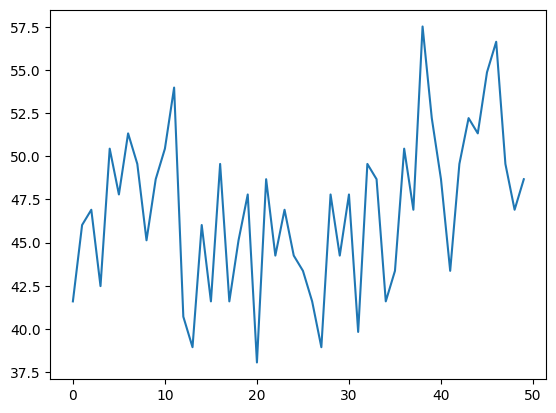

In [23]:
plt.plot(sample_percentage)

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [25]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [26]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = ( precision , recall, (2*precision*recall)/(precision+recall))
    return score

In [27]:
f1_test = []
acc_test = []
for i in range(1,ensemble_size+1):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    acc_test.append(accuracy_score(test_result, ans))

*********: 0
4/4 [==============================] - 0s 36ms/step


2022-11-15 12:08:46.772708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/var/folders/w9/17dx1py559xc12bhjgp9w4_80000gn/T/ipykernel_11741/354829567.py:3: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+ fp)


*********: 0
4/4 [==============================] - 0s 6ms/step
*********: 1
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 2ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-15 12:08:47.051921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 7ms/step
*********: 2
4/4 [==============================] - 0s 17ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-15 12:08:47.309594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 4ms/step
*********: 2
4/4 [==============================] - 0s 7ms/step
*********: 3
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 6ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-15 12:08:47.623063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step
*********: 2
4/4 [==============================] - 0s 9ms/step
*********: 3
4/4 [==============================] - 0s 6ms/step
*********: 4
4/4 [==============================] - 0s 16ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 6ms/step


2022-11-15 12:08:48.020181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 6ms/step
*********: 3
4/4 [==============================] - 0s 8ms/step
*********: 4
4/4 [==============================] - 0s 6ms/step
*********: 5
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 5ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step


2022-11-15 12:08:48.442895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 13ms/step
*********: 0
4/4 [==============================] - 0s 5ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-15 12:08:48.868278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 6ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 7ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 9ms/step
*********: 7
4/4 [==============================] - 0s 25ms/step
*********: 0
4/4 [==============================] - 0s 2ms/step


2022-11-15 12:08:49.415409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 7ms/step
*********: 5
4/4 [==============================] - 0s 6ms/step
*********: 6
4/4 [==============================] - 0s 7ms/step
*********: 7
4/4 [==============================] - 0s 8ms/step
*********: 8
4/4 [==============================] - 0s 20ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step


2022-11-15 12:08:49.994416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 6ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 11ms/step
*********: 6
4/4 [==============================] - 0s 6ms/step
*********: 7
4/4 [==============================] - 0s 6ms/step
*********: 8
4/4 [==============================] - 0s 6ms/step
*********: 9
4/4 [==============================] - 0s 16ms/step
*********: 0
4/4 [==============================] - 0s 6ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step


2022-11-15 12:08:50.643946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 11ms/step
*********: 5
4/4 [==============================] - 0s 8ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 16ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step


2022-11-15 12:08:51.280709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 4ms/step
*********: 7
4/4 [==============================] - 0s 6ms/step
*********: 8
4/4 [==============================] - 0s 5ms/step
*********: 9
4/4 [==============================] - 0s 7ms/step
*********: 10
4/4 [==============================] - 0s 9ms/step
*********: 11
4/4 [==============================] - 0s 14ms/step
*********: 0
4/4 [==============================] - 0s 2ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step
*********: 2
1/4 [======>.......................] - ETA: 0s

2022-11-15 12:08:51.959024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 8ms/step
*********: 9
4/4 [==============================] - 0s 5ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 14ms/step
*********: 0
4/4 [==============================] - 0s 5ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step


2022-11-15 12:08:52.611156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 4ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 6ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 8ms/step
*********: 13
4/4 [==============================] - 0s 17ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step


2022-11-15 12:08:53.343090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 6ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 5ms/step
*********: 12
4/4 [==============================] - 0s 5ms/step
*********: 13
4/4 [==============================] - 0s 8ms/step
*********: 14
4/4 [==============================] - 0s 15ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step


2022-11-15 12:08:54.129592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 6ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 5ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 7ms/step
*********: 15
4/4 [==============================] - 0s 16ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [===============

2022-11-15 12:08:54.911691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 4ms/step
*********: 9
4/4 [==============================] - 0s 10ms/step
*********: 10
4/4 [==============================] - 0s 6ms/step
*********: 11
4/4 [==============================] - 0s 7ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 6ms/step
*********: 15
4/4 [==============================] - 0s 6ms/step
*********: 16
4/4 [==============================] - 0s 19ms/step
*********: 0
4/4 [=============

2022-11-15 12:08:55.810992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 4ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 6ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 5ms/step
*********: 12
4/4 [==============================] - 0s 6ms/step
*********: 13
4/4 [==============================] - 0s 6ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 8ms/step
*********: 16
4/4 [==============================] - 0s 5ms/step
*********: 17
4/4 [==============

2022-11-15 12:08:56.732001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 5ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:08:57.618810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 5ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 5ms/step
*********: 17
4/4 [==============

2022-11-15 12:08:58.554846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 8ms/step
*********: 16
4/4 [==============================] - 0s 7ms/step
*********: 17
4/4 [==============

2022-11-15 12:08:59.557851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 4ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 5ms/step
*********: 16
4/4 [==============================] - 0s 8ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:00.690441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:01.777221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:02.860511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 6ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:03.988541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 5ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 5ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:05.193995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:06.416572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 4ms/step
*********: 3
4/4 [==============================] - 0s 4ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:07.690287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:08.940666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 3ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:10.266497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 3ms/step
*********: 17
4/4 [==============================] - 0s 3ms/step
*********: 18
4/4 [=============

2022-11-15 12:09:11.705807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:13.122553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 4ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:14.591408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:16.047544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:17.579743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 4ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============================] - 0s 3ms/step
*********: 18
4/4 [=============

2022-11-15 12:09:19.095690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 4ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:20.693339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 3ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:22.297805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 4ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:24.072851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 3ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 3ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:26.014930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 3ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 3ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:27.773304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:29.579265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:31.390811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:33.273517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 3ms/step
*********: 16
4/4 [==============================] - 0s 3ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:35.281684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 3ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:37.237770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============================] - 0s 3ms/step
*********: 18
4/4 [=============

2022-11-15 12:09:39.172960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 3ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [===========================

2022-11-15 12:09:41.214381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 2
4/4 [==============================] - 0s 2ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 2ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 2ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 2ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 2ms/step
*********: 17
4/4 [==============

2022-11-15 12:09:43.257028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [==============================] - 0s 2ms/step
*********: 8
4/4 [==============================] - 0s 3ms/step
*********: 9
4/4 [==============================] - 0s 2ms/step
*********: 10
4/4 [==============================] - 0s 3ms/step
*********: 11
4/4 [==============================] - 0s 2ms/step
*********: 12
4/4 [==============================] - 0s 3ms/step
*********: 13
4/4 [==============================] - 0s 2ms/step
*********: 14
4/4 [==============================] - 0s 2ms/step
*********: 15
4/4 [==============================] - 0s 2ms/step
*********: 16
4/4 [==============================] - 0s 5ms/step
*********: 17
4/4 [==============================] - 0s 3ms/step
*********: 18
4/4 [=============

2022-11-15 12:09:45.408527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [28]:
f1_train = []
acc_train = []
for i in range(1,ensemble_size+1):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    acc_train.append(accuracy_score(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
36/36 [==============================] - 0s 3ms/step
*********: 0
36/36 [==============================] - 0s 5ms/step
*********: 1
36/36 [==============================] - 0s 4ms/step
*********: 0
36/36 [==============================] - 0s 2ms/step
*********: 1
36/36 [==============================] - 0s 3ms/step
*********: 2
36/36 [==============================] - 0s 3ms/step
*********: 0
36/36 [==============================] - 0s 3ms/step
*********: 1
36/36 [==============================] - 0s 3ms/step
*********: 2
36/36 [==============================] - 0s 2ms/step
*********: 3
36/36 [==============================] - 0s 3ms/step
*********: 0
36/36 [==============================] - 0s 2ms/step
*********: 1
36/36 [==============================] - 0s 2ms/step
*********: 2
36/36 [==============================] - 0s 3ms/step
*********: 3
36/36 [==============================] - 0s 3ms/step
*********: 4
36/36 [==============================] - 0s 3ms/step
*********:

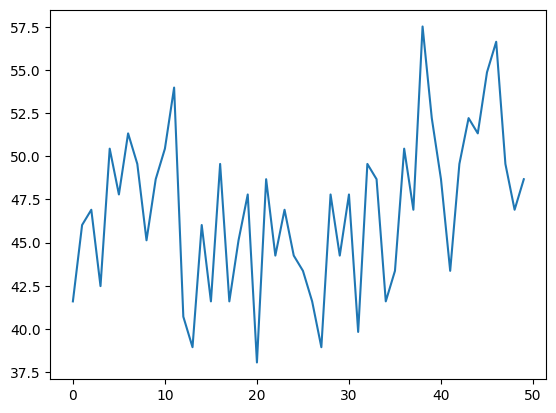

In [29]:
plt.plot(sample_percentage)

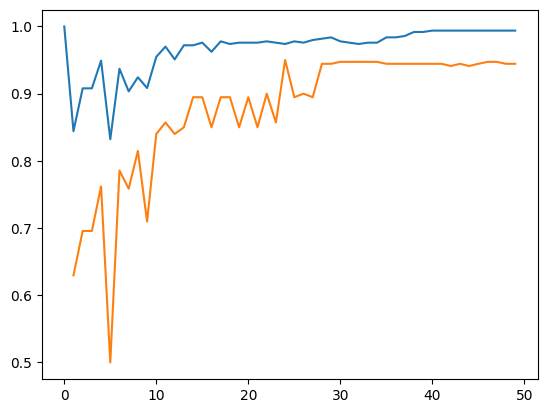

In [30]:
plt.plot([i[0] for i in f1_train])
plt.plot([i[0] for i in f1_test])
# plt.plot()

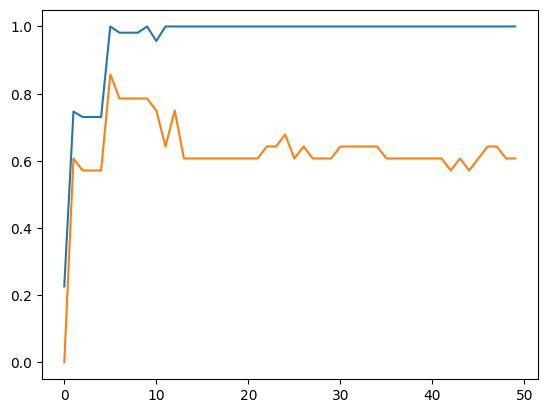

In [31]:
plt.plot([i[1] for i in f1_train])
plt.plot([i[1] for i in f1_test])

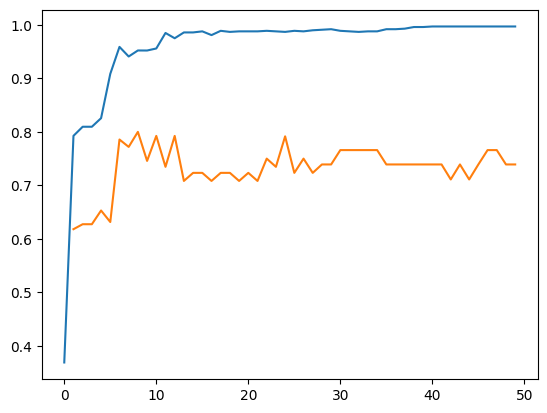

In [32]:
plt.plot([i[2] for i in f1_train])
plt.plot([i[2] for i in f1_test])

In [ ]:
plt.plot(acc_train)
plt.plot(acc_test)

In [40]:
f1_train[12]

(0.9510763209393346, 1.0, 0.9749247743229689)

In [52]:
value = 12
data = some_pred(training_split, value+1)
ans = majority(data)
data = some_pred(test_split, value +1)
ans1 = majority(data)


*********: 0
36/36 [==============================] - 0s 3ms/step
*********: 1
36/36 [==============================] - 0s 2ms/step
*********: 2
36/36 [==============================] - 0s 2ms/step
*********: 3
36/36 [==============================] - 0s 3ms/step
*********: 4
36/36 [==============================] - 0s 2ms/step
*********: 5
36/36 [==============================] - 0s 2ms/step
*********: 6
36/36 [==============================] - 0s 2ms/step
*********: 7
36/36 [==============================] - 0s 2ms/step
*********: 8
36/36 [==============================] - 0s 2ms/step
*********: 9
36/36 [==============================] - 0s 2ms/step
*********: 10
36/36 [==============================] - 0s 3ms/step
*********: 11
36/36 [==============================] - 0s 3ms/step
*********: 12
36/36 [==============================] - 0s 2ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 

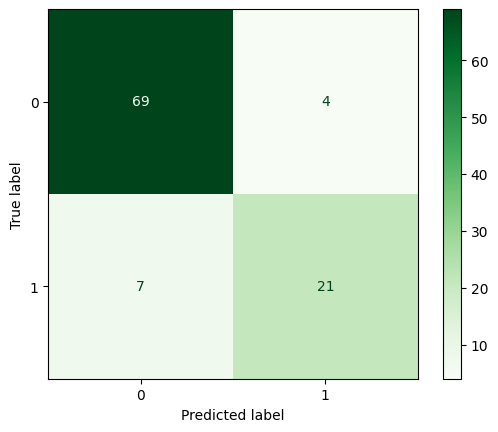

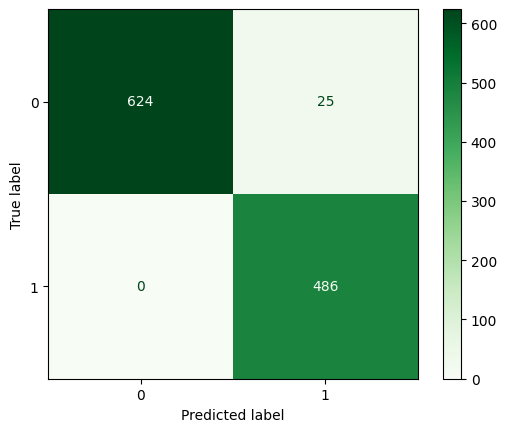

In [54]:
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [56]:
value = 32
data = some_pred(training_split, value+1)
ans = majority(data)
data = some_pred(test_split, value+1 )
ans1 = majority(data)

*********: 0
36/36 [==============================] - 0s 3ms/step
*********: 1
36/36 [==============================] - 0s 3ms/step
*********: 2
36/36 [==============================] - 0s 2ms/step
*********: 3
36/36 [==============================] - 0s 3ms/step
*********: 4
36/36 [==============================] - 0s 2ms/step
*********: 5
36/36 [==============================] - 0s 2ms/step
*********: 6
36/36 [==============================] - 0s 3ms/step
*********: 7
36/36 [==============================] - 0s 3ms/step
*********: 8
36/36 [==============================] - 0s 3ms/step
*********: 9
36/36 [==============================] - 0s 3ms/step
*********: 10
36/36 [==============================] - 0s 3ms/step
*********: 11
36/36 [==============================] - 0s 3ms/step
*********: 12
36/36 [==============================] - 0s 3ms/step
*********: 13
36/36 [==============================] - 0s 2ms/step
*********: 14
36/36 [==============================] - 0s 3ms/step
*****

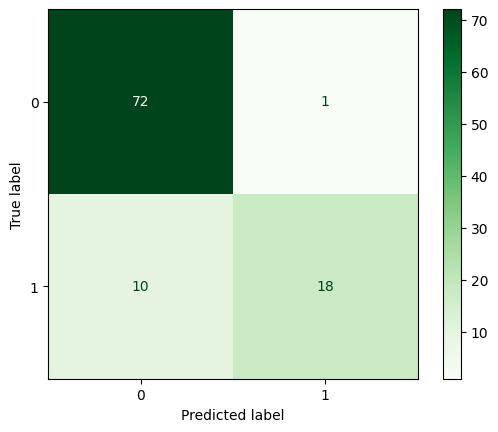

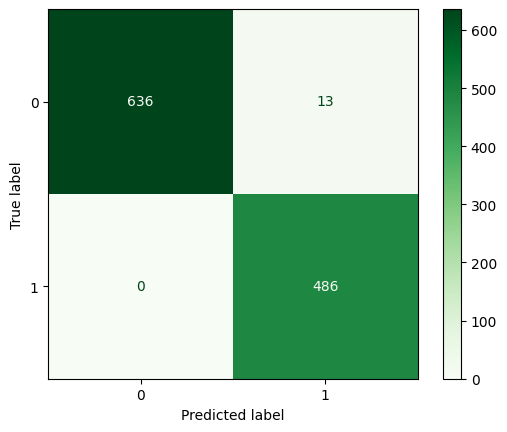

In [58]:
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [59]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 32+1))

*********: 0
11/11 [==============================] - 0s 6ms/step
*********: 1
11/11 [==============================] - 0s 5ms/step
*********: 2
11/11 [==============================] - 0s 2ms/step
*********: 3
11/11 [==============================] - 0s 5ms/step
*********: 4
11/11 [==============================] - 0s 3ms/step
*********: 5
11/11 [==============================] - 0s 4ms/step
*********: 6
11/11 [==============================] - 0s 3ms/step
*********: 7
11/11 [==============================] - 0s 2ms/step
*********: 8
11/11 [==============================] - 0s 2ms/step
*********: 9
11/11 [==============================] - 0s 4ms/step
*********: 10
11/11 [==============================] - 0s 3ms/step
*********: 11
11/11 [==============================] - 0s 2ms/step
*********: 12
11/11 [==============================] - 0s 3ms/step
*********: 13
11/11 [==============================] - 0s 3ms/step
*********: 14
11/11 [==============================] - 0s 2ms/step
*****

In [60]:
len(predicted_data)

350

In [61]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], predicted_data))
outfile.close()